# Monte Carlo Ising Model 2D

In [2]:
import numpy as np
from numba import jit
import math as math
import matplotlib.pyplot as plt
import statistics as stats
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from random import randint
from scipy import stats

import timeit
%matplotlib inline

# Constants

In [15]:

J=1 #Strength of interaction (Joules)
K = 1 #Joules per kelvin


size_grid=np.array([2,6,10,15])# Different sizes of grid to be used
T=np.linspace(0.5,10,20) #Array of temperature to be used


In [3]:
# This function performs the clusterization of the lattice according  Hoshen-Kopelman algorithm.
# Inputs: 
#         grid - the grid that is going to be used as an square matrix of ones if previously the set of spins are magnetized
#         size_grid - the size of the grid, this can be an array of numbers indicating the  
#                     different sizes of the square grid that are going to be analyzed
#         T- An array of temperatures
# Outputs:
#        grid- Update grid 
#        cluster-Array of the same size as grid of labels indicating spins aligned in the same direction using the 
#               Hoshen-Kopelman algorthim
#        H-Array with the Hamiltonian per each spin site
#        m-Magnetization all over the grid, a number each temperature and lattice size

def hk_cluster(grid,size_grid,T):
    
    beta = 1/T
    largest_label = 0
    
    
# Run over the whole lattice and identify groups of neighbours spins of the same sign to create different cluster with them
#         for i in range(cluster_steps):
            

for i in range(cluster_steps):
    m[i]=np.sum(grid)/(size_grid)**2
    for x in range(size_grid):
        for y in range(size_grid):
        top = grid[np.mod(x-1,size_grid),y]
        left = grid[x,np.mod(y-1,size_grid)]
        # Energy calculation with the neighbours spins, a hamiltonian for each site of spins
        H[x,y]=J*grid[x,y]*top*left
        DeltaE=2*H[x,y]*J
        probability = 1 - np.exp(-beta*DeltaE)
        if( (left != grid[x,y]) and (top != grid[x,y]) ):
            largest_label += 1
            cluster[x,y] = largest_label
        elif( (left == grid[x,y]) and  (top != grid[x,y]) ):
            if (np.random.rand() < probability):
                cluster[x,y] = cluster[x,np.mod(y-1,size_grid)]
        elif( (top == grid[x,y]) and  (left != grid[x,y]) ):
            if (np.random.rand() < probability):
                cluster[x,y] = cluster[np.mod(x-1,size_grid),y]
        elif( (top == grid[x,y]) and  (left == grid[x,y]) ):
            cluster[x,y] = np.amin(cluster[np.mod(x-1,size_grid),y], cluster[x,np.mod(y-1,size_grid)])

        if (transitions = (np.random.rand() < probability * (-2) + 1):
            grid[x,y]*= transitions
                    
                
                    
                    

            
        
    return grid,cluster,H,m


In [7]:
#comments
@jit
def update(grid,size_grid,T):
    # Monte carlo loop
    for b in range(mcsteps):
        m[b]=np.sum(grid)/(size_grid)**2  # average of the magnetization(magnetization per spin)
#         m[b]=np.sum(grid)
    # Metropolis loop      
        for i in range(msteps): # equilibration steps to led the system relax after change one step of the temperature
            h=np.rint((size_grid-1)*np.random.rand())
            k=np.rint((size_grid-1)*np.random.rand())
            # calculating the number of neighbours of each cell
            neighbours=grid[np.mod(h+1,size_grid),k]+grid[np.mod(h-1,size_grid),k]+grid[h,np.mod(k+1,size_grid)]+grid[h,np.mod(k-1,size_grid)]       

            # Computing the halmiltonian for this spin j,k
            H[i]=J*grid[h,k]*neighbours
            #Calculating the change in energy by flipping a spin
            DeltaE=2*H[i]*J
            #Calculate the transition probabilities
            p_trans = np.exp(-DeltaE*1/(T))
            #Decide which transition will occur
            transitions = (np.random.rand() < p_trans) * (-2) + 1

            #Perform the transitions
            grid[h,k] *= transitions
            
       
        
    return grid,H,m


In [8]:
#comments
def simulation(grid,H,T,size_grid,m):

    # Energy per spin. factor of a half is introduced in order to account for the spins being counted twice. 
    E=-np.sum(H)/((size_grid)**2 )

    # Specific heat per site in units of J/K (eq 7.28 book)(k/J*tau*T=1/kT*T)
    cv=(np.mean(H*H)-np.mean(np.absolute(H))*np.mean(np.absolute(H)))/T**2
    
    # Susceptibility per spin (first value as the initial, which is zero)
    phi=(np.mean(m*m)-np.mean(np.absolute(m))*np.mean(np.absolute(m)))/T  # (<M^2>-<absM><absM>)/T
    return cv, E, phi



In [125]:
# Function that computes the critical exponents at different lattice sizes of one magnitud of interest.
#inputs:
#       size_grid- Different sizes of the grid used
#       A- array of size of temperatures x size of size_grid of the magnitud to compute the critical exponent
#       b- string with the name of the magnitud, they can be: Magnetization,Heat Capacity,Susceptibility
#       T- array of the temperatures used
#outputs
def critical(size_grid,A,b,T):
    ratio=np.zeros(shape=(len(size_grid),))
    t=len(T)
    if (str(b)=='Magnetization'):
        for j in range(len(size_grid)):
            c=A[:]
            c[0:t/3,j]=0.8
    if (str(b)=='Heat Capacity'):
        ratiocv=np.zeros(shape=(len(size_grid),))
        for i in range(len(size_grid)):
            kcv=np.amax(A[:,i]) 
            l=np.log(size_grid)
            ratiocv[i]=kcv/l[i]
    
        z=np.polyfit(l,ratiocv,1)
        p = np.poly1d([z[0],z[1]])
        slope=z[0]
        crit=plt.figure(1)
        phiplot=plt.scatter(l, ratiocv,label='Data points')
        phiplot=plt.plot(l, p(l),label='Linear Fit'+  ',slope=%f'%(slope))
        plt.title(str(b)+' vs Ln of Lattice size')
        
    elif (str(b)!='Heat Capacity' ):
        for i in range(len(size_grid)):
            k=np.log(np.amax(A[:,i]))
            l=np.log(size_grid)
            ratio[i]=k/l[i]
        
    
        z=np.polyfit(l,ratio,1)
        p = np.poly1d([z[0],z[1]])
        slope=z[0]
        crit=plt.figure(1)
        phiplot=plt.scatter(l, ratio,label='Data points')
        phiplot=plt.plot(l, p(l),label='Linear Fit'+  ',slope=%f'%(slope))
        plt.title('Ln of ' + str(b) + ' vs Ln of lattice size')

    plt.xlabel('Ln lattice sizes')
    plt.ylabel('Data points and a polynomio fit')
    legend = plt.legend(loc=4,fontsize=9)
    return slope,crit

In [12]:
# Function that compute the exact solution according Onsanger for an infinite lattice to compare with my solution
# input :
#       T- array of teh temperatures used
# output:
#      Mexact- array of the exact magnetization computed by Onsager
def exact2D(T):
    Tc=2.269
    # Onsager solution 
    if T<Tc:
        Mexact=math.pow((1-math.pow(math.sinh(math.log(1+math.sqrt(2))*Tc/T),-4)),1/8) 
    else:
        Mexact=0                    
    return Mexact

In [116]:
# Plotting the observables along with the different sizes of the grid that have been taken
#comments
# input:
#       A-magnitud to be plotted
#       size_grid- Array of the differnt lattices sizes used
#       b- string with the name of the magnitud in A
# output:
#       figA-handle for the plotting


def plotting(A,size_grid,b):
    colors = ['aquamarine', 'c', 'y', 'm', 'r']
    figA=plt.figure(1)
    plt.subplot(1,1,1)
    plt.title(str(b) + ' vs Temp')
    plt.xlabel('Temperature[J/k]', fontsize=10)
    plt.ylabel(str(b),fontsize=10)
    
    for i in range(len(size_grid)):
        mylegend=['L=2','L=6','L=10','L=15']# built this vector according size_grid
#         mylegend=['L=50']
        phiplot=plt.scatter(T, A[:,i], color=colors[i],label=mylegend[i])
        phiplot=plt.plot(T, A[:,i], color=colors[i])
        legend = plt.legend(loc=4)
    plt.show()  
    
    return figA

# Ising and observables using update function

In [114]:
# Script to run the Metropolis algorithm and calculate the observables
# size_grid=np.array([2,6,10,15])
# size_grid=np.array([50])
#Monte Carlo steps
mcsteps=50
cv=np.zeros(shape=(len(T),len(size_grid))) #init heat capacity
M=np.zeros(shape=(len(T),len(size_grid))) #init magnetization for plotting
phi=np.zeros(shape=(len(T),len(size_grid))) # init susceptibility
E=np.zeros(shape=(len(T),len(size_grid))) # init Energy
m=np.zeros(shape=(mcsteps))# init average magnetization



for j in range(len(size_grid)):
    msteps=size_grid[j]*size_grid[j]
    H=np.zeros(shape=(msteps),) #init hamiltonian
    grid=np.zeros(shape=(size_grid[j],size_grid[j]))
    grid+=1
    for t in range(len(T)):
        cv[t,j],E[t,j],phi[t,j]=simulation(grid,H,T[t],size_grid[j],m)
        grid,H,m=update(grid,size_grid[j],T[t])
        M[t,j]=m[len(m)-1]

        

   
   
   

C:\Users\Bas\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Ising observables using cluster_hk function

In [ ]:
# Script to run the Metropolis algorithm and calculate the observables
# size_grid=np.array([2,6,10,15])
# size_grid=np.array([50])
cluster_steps=100
cv=np.zeros(shape=(len(T),len(size_grid))) #init heat capacity
M=np.zeros(shape=(len(T),len(size_grid))) #init magnetization for plotting
phi=np.zeros(shape=(len(T),len(size_grid))) # init susceptibility
E=np.zeros(shape=(len(T),len(size_grid))) # init Energy
m=np.zeros(shape=(len(cluster_steps)))# init magnetization per each cluster steps

for j in range(len(size_grid)):
    msteps=size_grid[j]*size_grid[j]
    H=np.zeros(shape=(len(size_grid),len(size_grid))) #init hamiltonian
    cluster=np.zeros(shape=(size_grid[j],size_grid[j])) #init cluster
    grid=np.zeros(shape=(size_grid[j],size_grid[j]))
    grid+=1
    for t in range(len(T)):
        cv[t,j],E[t,j],phi[t,j]=simulation(grid,H,T[t],size_grid[j],m)
        grid,cluster,H,m=hk_cluster(grid,size_grid[j],T[t])
        M[t,j]=m[len(m)-1]

# Saving observables



In [ ]:
heat=np.savetxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\cv_latt2.txt', cv, delimiter='\n') 
    
ene=np.savetxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\E_latt2.txt', E, delimiter='\n')  
    
mag=np.savetxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\M_latt2.txt', M, delimiter='\n')  

sus=np.savetxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\phi_latt2.txt', phi, delimiter='\n')  
            
                

In [ ]:
# Function to read the data of the observables as arrays
#inputs:
#       data- output of the np.loadtxt of a file that you want to use previously saved as txt
#       size_grid - Array of the sizes of the grid, is a global variable defined in the constants section
#output:
#      a- array with the data stored organized in the way where the number of columns is the size of the grid and the number of
#         rows is the amount of temperatures used

def readdata(data,size_grid):
    t=len(data)/len(size_grid)
    t1=np.zeros(shape=(t,))
    a=np.zeros(shape=(len(data)/len(size_grid),len(size_grid)))
    for i in range(len(t1)):
        a[i,:]=data[i*len(size_grid):i*len(size_grid)+len(size_grid)]
    return a

In [ ]:
# Load the variable you want to read from

phi=np.loadtxt('G:\Maestria\Computational Physics\Project 2 Monte Carlo Ising Model\observables savings\phi_latt2.txt')
phi=readdata(phi,size_grid)



# Exact observables

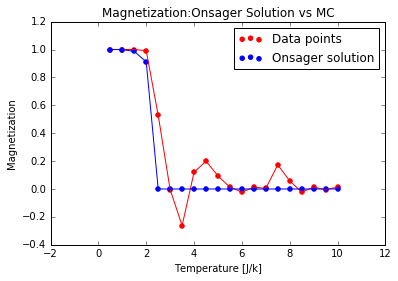

In [24]:
#Script to plot the exact results looking at the Onsager solution for the magnetization

Mexact=np.zeros(shape=(len(T),))
for i in range(len(T)):
    Mexact[i]=exact2D(T[i])

mc=plt.figure(1)
plt.scatter(T,M,color='r',label='Data points')
plt.plot(T,M,color='r')
plt.scatter(T,Mexact,color='b',label='Onsager solution')
plt.plot(T,Mexact,color='b')
plt.title('Magnetization:Onsager Solution vs MC')
plt.xlabel('Temperature [J/k]')
plt.ylabel('Magnetization')
plt.legend(loc=1)

# Plotting

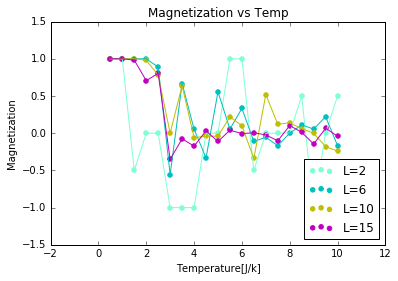

In [117]:
figa=plotting(M,size_grid,'Magnetization')

# Critical exponents

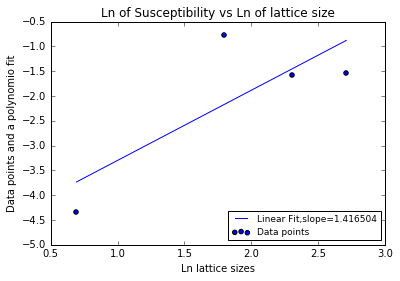

In [127]:
# Critical exponents script

slope,crit=critical(size_grid,phi,'Susceptibility',T)

